# Regression on subgroups
This Notebook will look in more detail at some factors that affect the connection between the number of casualties and vehicles in an accident. It does this by splitting the accidents dataset into two groups: those involving bus-like vehicles and those that don't, and comparing regression tests between the two groups.

In [1]:
# Import the required libraries

import pymongo
import datetime
import collections

import pandas as pd
import scipy.stats

In [2]:
# Open a connection to the Mongo server, open the accidents database and name the collections of accidents and labels
client = pymongo.MongoClient('mongodb://localhost:27351/')

db = client.accidents
accidents = db.accidents
labels = db.labels

In [3]:
# Load the expanded names of keys and human-readable codes into memory

expanded_name = collections.defaultdict(str)
for e in labels.find({'expanded': {"$exists": True}}):
    expanded_name[e['label']] = e['expanded']
    
label_of = collections.defaultdict(str)
for l in labels.find({'codes': {"$exists": True}}):
    for c in l['codes']:
        try:
            label_of[l['label'], int(c)] = l['codes'][c]
        except ValueError: 
            label_of[l['label'], c] = l['codes'][c]

## Pearson's *R*²
Let's look again at the whole set.

In [4]:
# Build a DataFrame, one row for each accident
cas_veh_unrolled_df = pd.DataFrame(list(accidents.find({}, ['Number_of_Casualties', 'Number_of_Vehicles'])))

# Count the number of each severity
cas_veh_df = pd.crosstab(cas_veh_unrolled_df['Number_of_Casualties'], 
                                      cas_veh_unrolled_df['Number_of_Vehicles'])
# Reshape
cas_veh_long_df = cas_veh_df.stack().reset_index()
cas_veh_long_df

,Number_of_Casualties,Number_of_Vehicles,0
0,1,1,39217
1,1,2,65680
2,1,3,6168
3,1,4,1056
4,1,5,197
5,1,6,76
6,1,7,27
7,1,8,4
8,1,9,1
9,1,10,1


In [5]:
regressionline = scipy.stats.linregress(cas_veh_unrolled_df['Number_of_Casualties'],
                                       cas_veh_unrolled_df['Number_of_Vehicles'])

# The regression line is of the form y = m x + b
m = regressionline[0]
b = regressionline[1]
(m, b)

(0.21101011188488833, 1.5427349394560317)

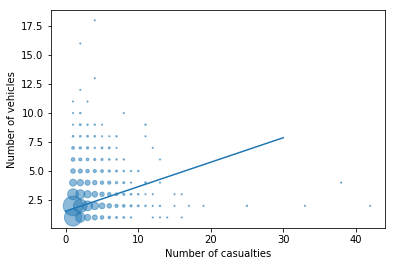

In [6]:
plt.scatter(cas_veh_long_df['Number_of_Casualties'], 
            cas_veh_long_df['Number_of_Vehicles'],
            s=np.sqrt(cas_veh_long_df[0])*1.5,
            alpha=0.5
            )

x = np.linspace(0, 30, 20)
plt.plot(x, m*x + b)

plt.xlabel('Number of casualties')
plt.ylabel('Number of vehicles')
plt.show()

The `pearsonr` function calculates Pearson's *R*² value of correlation. Recall that values near +1 show good positive correlation, values near -1 show good negative correlation, and values near 0 show no particular correlation. The `scipy` function returns a second value, the *p* value of the result. 

In [7]:
scipy.stats.pearsonr(cas_veh_unrolled_df['Number_of_Casualties'], 
                     cas_veh_unrolled_df['Number_of_Vehicles'])

(0.2415849093923253, 0.0)

This result shows a small, positive correlation with a very small *p* value. In other words, there's not much correlation, and the result is statistically significant. This means we can reject the the null hypothesis that the number of casualties in an accident is unrelated to the number of vehicles.

Looking at the data, it seems to be a result that most accidents result in very few casualties, and the accidents with the most casualties have few vehicles.

Let's look at why the accidents with most casualties seem to only involve a few vehicles. 

### Activity 1
Investigate the types of vehicles that are involved in the largest accidents (i.e. those accidents with more than 8 casualties). What types of vehicles appear in the multiple-casualty accidents?

For each accident with more than 8 casualties, list the vehicles involved. For each vehicle, print the type of vehicle and the number of casualties in it, in a format similar to this:

```
Acc index 201201GD10531; 9 casualties, 3 vehicles
	Car: 1 casualties
	Car: 5 casualties
	Bus: 3 casualties
Acc index 201201KF60687; 11 casualties, 3 vehicles
	Taxi/Private: 2 casualties
	Taxi/Private: 4 casualties
	Taxi/Private: 5 casualties
```

**Hint**

Because you'll want to look at the vehicles involved in each accident, it's easier to keep the data in standard Python data structures, unchanged from the result of a pymongo `find()`.

The solution is in the [`14.4solutions`](14.4solutions.ipynb) Notebook.

In [8]:
big_accidents = [a for a in accidents.find({'Number_of_Casualties': {'$gt': 8}},
                                          ['Accident_Index',
                                           'Number_of_Casualties', 'Number_of_Vehicles',
                                           'Vehicles.Vehicle_Type', 'Vehicles.Vehicle_Reference',
                                           'Casualties.Vehicle_Reference'])]
len(big_accidents)

66

In [9]:
for a in big_accidents:
    print('Acc index {}; {} casualties, {} vehicles'.format(a['Accident_Index'],
                                                           a['Number_of_Casualties'],
                                                           a['Number_of_Vehicles']))
    for v in a['Vehicles']:
        print('\t{}: {} casualties'.format(label_of[('Vehicle_Type', v['Vehicle_Type'])].split()[0],
                                          len([c
                                              for c in a['Casualties']
                                              if c['Vehicle_Reference'] == v['Vehicle_Reference']])
                                          ))

Acc index 201201GD10531; 9 casualties, 3 vehicles
	Car: 1 casualties
	Car: 5 casualties
	Bus: 3 casualties
Acc index 201201KF60687; 11 casualties, 3 vehicles
	Taxi/Private: 2 casualties
	Taxi/Private: 4 casualties
	Taxi/Private: 5 casualties
Acc index 201201WW50958; 10 casualties, 3 vehicles
	Car: 4 casualties
	Taxi/Private: 3 casualties
	Car: 3 casualties
Acc index 201204EA12275; 9 casualties, 2 vehicles
	Car: 0 casualties
	Minibus: 9 casualties
Acc index 201205EE01017; 9 casualties, 2 vehicles
	Car: 4 casualties
	Bus: 5 casualties
Acc index 201205EE03703; 12 casualties, 1 vehicles
	Bus: 12 casualties
Acc index 201205EE06006; 9 casualties, 3 vehicles
	Car: 3 casualties
	Car: 4 casualties
	Car: 2 casualties
Acc index 201205FF02477; 9 casualties, 2 vehicles
	Car: 0 casualties
	Car: 9 casualties
Acc index 201205FF05784; 9 casualties, 2 vehicles
	Minibus: 7 casualties
	Car: 2 casualties
Acc index 201205FF06439; 9 casualties, 2 vehicles
	Motorcycle: 1 casualties
	Other: 8 casualties
Acc in

### Activity 2
Separate out the types of accidents into those involving bus-like vehicles and those that don't, and calculate the regression scores for the subgroups.

The solution is in the [`14.4solutions`](14.4solutions.ipynb) Notebook.

In [10]:
# What are the vehicle types?
[(code, label_of[(key, code)]) for key, code in label_of if key == 'Vehicle_Type']

[(98, 'Goods vehicle - unknown weight'),
 (20, 'Goods over 3.5t. and under 7.5t'),
 (19, 'Van / Goods 3.5 tonnes mgw or under'),
 (105, 'Motorcycle - Combination'),
 (106, 'Motorcycle over 125cc'),
 (1, 'Pedal cycle'),
 (8, 'Taxi/Private hire car'),
 (22, 'Mobility scooter'),
 (3, 'Motorcycle 125cc and under'),
 (10, 'Minibus (8 - 16 passenger seats)'),
 (17, 'Agricultural vehicle'),
 (109, 'Car (including private hire cars)'),
 (5, 'Motorcycle over 500cc'),
 (90, 'Other vehicle'),
 (97, 'Motorcycle - unknown cc'),
 (-1, 'Data missing or out of range'),
 (104, 'Motorcycle'),
 (21, 'Goods 7.5 tonnes mgw and over'),
 (2, 'Motorcycle 50cc and under'),
 (113, 'Goods vehicle over 3.5 tonnes'),
 (9, 'Car'),
 (16, 'Ridden horse'),
 (108, 'Taxi (excluding private hire cars)'),
 (4, 'Motorcycle over 125cc and up to 500cc'),
 (11, 'Bus or coach (17 or more pass seats)'),
 (23, 'Electric motorcycle'),
 (18, 'Tram'),
 (103, 'Motorcycle - Scooter'),
 (110, 'Minibus/Motor caravan')]

In [11]:
# Build a DataFrame, one row for each accident
coach_unrolled_df = pd.DataFrame(list(accidents.find({'Vehicles.Vehicle_Type': {'$in': [10, 11]}}, 
                                                       ['Number_of_Casualties', 'Number_of_Vehicles'])))
len(coach_unrolled_df)

6941

In [17]:
# check weve got them all...
non_coach_unrolled_df = pd.DataFrame(list(accidents.find({'Vehicles.Vehicle_Type': {'$not': {'$in': [10,11]}}},
                                                                       ['Number_of_Casualties', 'Number_of_Vehicles'])))
len(non_coach_unrolled_df)

TypeError: 'DataFrame' object is not callable

In [15]:
len(coach_unrolled_df) + len(non_coach_unrolled_df) == accidents.find().count()

True

### Find the regression for non-coach accidents


In [16]:
# Count the number of each severity
coach_df = pd.crosstab(coach_unrolled_df['Number_of_Casualties'],
                     coach_unrolled_df['Number_of_Vehicles'])
coach_df

TypeError: isinstance() arg 2 must be a type or tuple of types

## What next?
If you are working through this Notebook as part of an inline exercise, return to the module materials now.

If you are working through this set of Notebooks as a whole, you've completed the Part 14 Notebooks. It's time to move on to Part 15.